# PGGAN

**Module import**

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, Model
#import tensorflow.keras.preprocessing.image as prep 
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt

#from models import Generator_mnist, Discriminator_mnist
#from data_load import get_npdata, get_data_list, load_celeba_to_np

from IPython import display

**Set Parameter**

In [2]:
learning_rate = 0.0001  # alpha
gp_lambda = 10          # gradient penalty coefficient
n_critic = 5
b_1 = 0                 # Adam arg beta1
b_2 = 0.9               # Adam arg beta2
epochs = 200
batch_size = 64
noise_dim = 100
num_examples_to_generate = 16
BUFFER_SIZE = 60000     # mnist buffer size

**Data Load: MNIST**

In [3]:
(train_images, _), (_, _) = mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # image normalization [-1, 1]
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(batch_size)

11493376/11490434 [==============================] - 0s 0us/step


**Equalized Learning Rate**

In [4]:
class EqualizeLearningRate(tf.keras.layers.Wrapper):
    def __init__(self, layer, **kwargs):
        super(EqualizeLearningRate, self).__init__(layer, **kwargs)
        self._track_trackable(layer, name='layer')
        self.is_rnn = isinstance(self.layer, tf.keras.layers.RNN)

    def build(self, input_shape):
        """Build `Layer`"""
        input_shape = tf.TensorShape(input_shape)
        self.input_spec = tf.keras.layers.InputSpec(
            shape=[None] + input_shape[1:])

        if not self.layer.built:
            self.layer.build(input_shape)

        kernel_layer = self.layer.cell if self.is_rnn else self.layer

        if not hasattr(kernel_layer, 'kernel'):
            raise ValueError('`EqualizeLearningRate` must wrap a layer that'
                             ' contains a `kernel` for weights')

        if self.is_rnn:
            kernel = kernel_layer.recurrent_kernel
        else:
            kernel = kernel_layer.kernel

        # He constant
        self.fan_in, self.fan_out= self._compute_fans(kernel.shape)
        self.he_constant = tf.Variable(1.0 / np.sqrt(self.fan_in), dtype=tf.float32, trainable=False)

        self.v = kernel
        self.built = True
    
    def call(self, inputs, training=True):
        """Call `Layer`"""

        with tf.name_scope('compute_weights'):
            # Multiply the kernel with the he constant.
            kernel = tf.identity(self.v * self.he_constant)
            
            if self.is_rnn:
                print(self.is_rnn)
                self.layer.cell.recurrent_kernel = kernel
                update_kernel = tf.identity(self.layer.cell.recurrent_kernel)
            else:
                self.layer.kernel = kernel
                update_kernel = tf.identity(self.layer.kernel)

            # Ensure we calculate result after updating kernel.
            with tf.control_dependencies([update_kernel]):
                outputs = self.layer(inputs)
                return outputs

    def compute_output_shape(self, input_shape):
        return tf.TensorShape(
            self.layer.compute_output_shape(input_shape).as_list())
    
    def _compute_fans(self, shape, data_format='channels_last'):
        if len(shape) == 2:
            fan_in = shape[0]
            fan_out = shape[1]
        elif len(shape) in {3, 4, 5}:
            # Assuming convolution kernels (1D, 2D or 3D).
            # TH kernel shape: (depth, input_depth, ...)
            # TF kernel shape: (..., input_depth, depth)
            if data_format == 'channels_first':
                receptive_field_size = np.prod(shape[2:])
                fan_in = shape[1] * receptive_field_size
                fan_out = shape[0] * receptive_field_size
            elif data_format == 'channels_last':
                receptive_field_size = np.prod(shape[:-2])
                fan_in = shape[-2] * receptive_field_size
                fan_out = shape[-1] * receptive_field_size
            else:
                raise ValueError('Invalid data_format: ' + data_format)
        else:
            # No specific assumptions.
            fan_in = np.sqrt(np.prod(shape))
            fan_out = np.sqrt(np.prod(shape))
        return fan_in, fan_out

**PixelNormalization**

In [5]:
class PixelNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-8):
        super(PixelNormalization, self).__init__()
        self.epsilon = epsilon

    def call(self, inputs):
        return inputs / tf.sqrt(tf.reduce_mean(tf.square(inputs), axis=-1, keepdims=True) + self.epsilon)
    
    def compute_output_shape(self, input_shape):
        return input_shape

**MinibatchSTDDEV**

In [6]:
class MinibatchSTDDEV(tf.keras.layers.Layer):
    def __init__(self, group_size=4):
        super(MinibatchSTDDEV, self).__init__()
        self.group_size = group_size

    def call(self, inputs):
        group_size = tf.minimum(self.group_size, tf.shape(inputs)[0])     # Minibatch must be divisible by (or smaller than) group_size.
        s = inputs.shape                                             # [NHWC]  Input shape.
        y = tf.reshape(inputs, [group_size, -1, s[1], s[2], s[3]])   # [GMHWC] Split minibatch into M groups of size G.
        y = tf.cast(y, tf.float32)                              # [GMHWC] Cast to FP32.
        y -= tf.reduce_mean(y, axis=0, keepdims=True)           # [GMHWC] Subtract mean over group.
        y = tf.reduce_mean(tf.square(y), axis=0)                # [MHWC]  Calc variance over group.
        y = tf.sqrt(y + 1e-8)                                   # [MHWC]  Calc stddev over group.
        y = tf.reduce_mean(y, axis=[1,2,3], keepdims=True)      # [M111]  Take average over fmaps and pixels.
        y = tf.cast(y, inputs.dtype)                                 # [M111]  Cast back to original data type.
        y = tf.tile(y, [group_size, s[1], s[2], 1])             # [NHW1]  Replicate over group and pixels.
        return tf.concat([inputs, y], axis=-1)                        # [NHWC]  Append as new fmap.
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2], input_shape[3] + 1)

**Upsample, Downsample**

In [7]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    
    if use_bn:
        #x = layers.BatchNormalization()(x)
        x = PixelNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x

In [8]:
def downsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    
    if use_bn:
        #x = layers.BatchNormalization()(x)
        x = PixelNormalization()(x)
    x = activation(x)
    if use_dropout:
        #x = layers.Dropout(drop_value)(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
    return x

**Generator**

In [9]:
def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = EqualizeLearningRate(layers.Dense(4 * 4 * 256, use_bias=False), name='g_input_dense')(noise)
    x = PixelNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x, 1, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )

    # use a Cropping2D layer to make (32, 32, 1) → (28, 28, 1)
    x = layers.Cropping2D((2, 2))(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model

**Discriminator**

In [10]:
IMG_SHAPE = (28, 28, 1)

In [11]:
def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)
    # Zero pad the input to make the input images size to (32, 32, 1)
    x = layers.ZeroPadding2D((2, 2))(img_input)
    x = MinibatchSTDDEV()(x)
    x = downsample_block(
        x,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = downsample_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = downsample_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = downsample_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model

**Model load & Summary**

In [12]:
G = get_generator_model()
D = get_discriminator_model()

input1 = tf.keras.Input(shape=(100))
input2 = tf.keras.Input(shape=(28, 28, 1))

x1 = G(input1)
x2 = D(input2)

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
g_input_dense (EqualizeLearn (None, 4096)              409601    
_________________________________________________________________
pixel_normalization (PixelNo (None, 4096)              0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 128)         29

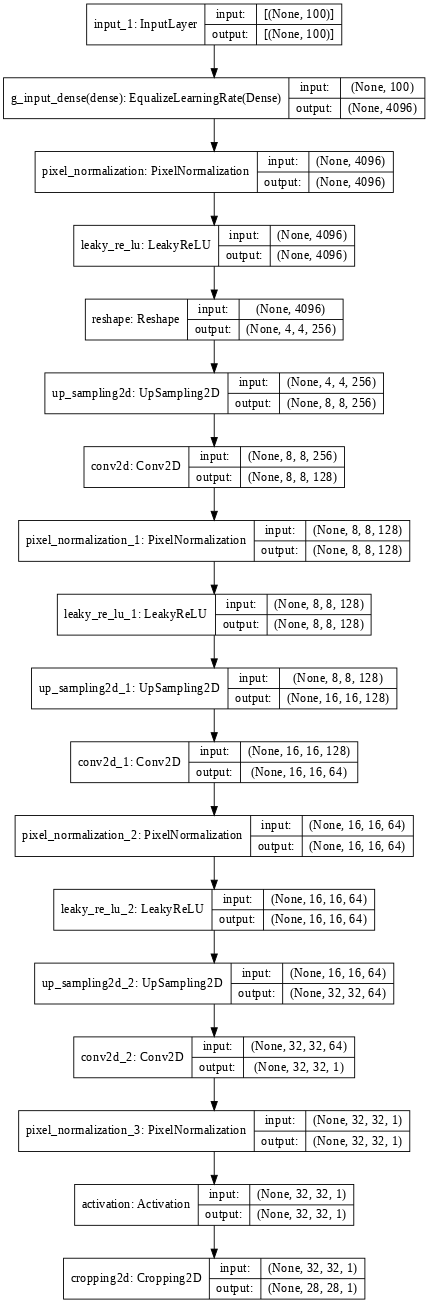

In [13]:
G.summary()
plot_model(G, show_shapes=True, dpi=64)

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 32, 32, 1)         0         
_________________________________________________________________
minibatch_stddev (MinibatchS (None, 32, 32, 2)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        3264      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)       

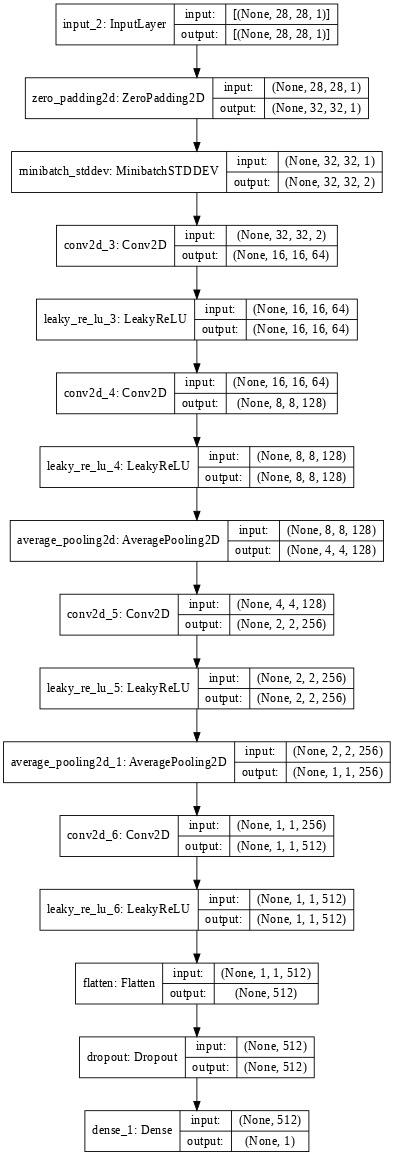

In [14]:
D.summary()
plot_model(D, show_shapes=True, dpi=64)

**Optimizer: Adam**

In [15]:
# Set optimizer
generator_optimizer = keras.optimizers.Adam(learning_rate, beta_1 = b_1, beta_2 = b_2)
discriminator_optimizer = keras.optimizers.Adam(learning_rate, beta_1 = b_1, beta_2 = b_2)

**고정된 seed에 대해 결과 이미지 변화**

In [16]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [17]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        # mnist
        plt.imshow(predictions[i, :, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

**Checkpoint Setting**

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 G=G,
                                 D=D)

**Train step function & loss**

In [19]:
def discriminator_train_step(images):
    len_batch = len(images)    # 마지막 batch에서의 length를 맞춰주기 위함
    noise = tf.random.normal([len_batch, noise_dim]) 
    
    with tf.GradientTape() as disc_tape:
        D.training = True
        generated_images = G(noise)
        real_output = D(images)
        fake_output = D(generated_images)
    
        #wgan loss
        disc_loss = K.mean(fake_output) - K.mean(real_output)

        eps = tf.random.uniform(shape=[len_batch, 1, 1, 1])
        x_hat = eps*images + (1 - eps)*generated_images
        
        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = D(x_hat)

        gradients = t.gradient(d_hat, [x_hat])  # gradients 계산
        l2_norm = K.sqrt(K.sum(K.square(gradients), axis=[2,3]))
        l2_norm = K.squeeze(l2_norm, axis=0)
        gradient_penalty = K.sum(K.square((l2_norm-1.)), axis=[1])
        disc_loss += gp_lambda*gradient_penalty
                
    gradients_of_discriminator = disc_tape.gradient(disc_loss, D.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, D.trainable_variables))
    
    return K.sum(disc_loss)

In [20]:
def generator_train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape:
        G.training = True
        generated_images = G(noise)
        fake_output = D(generated_images)
        
        #wgan loss
        gen_loss = - K.mean(fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, G.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, G.trainable_variables))    
    
    return K.sum(gen_loss)

**Training**

In [21]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        gen_loss_list = []
        disc_loss_list = []
        
        for image_batch in train_dataset:
            loss_d = 0
            for i in range(n_critic):
                loss_d += discriminator_train_step(image_batch)
            loss_g = generator_train_step(image_batch)
        
            gen_loss_list.append(loss_g)
            disc_loss_list.append(loss_d / n_critic)
            
        # 이미지 생성
        display.clear_output(wait=True)
        generate_and_save_images(G, epoch + 1, seed)
        
        # 15 epochs 지날 때마다 모델 저장
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        # loss & 시간 출력
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        #print ('G_Loss is {}, D_Loss is {}'.format(sum(gen_loss_list)/len(gen_loss_list), sum(disc_loss_list)/len(disc_loss_list)))

    # 학습이 끝난 후 이미지 생성
    display.clear_output(wait=True)
    generate_and_save_images(G, epochs, seed)

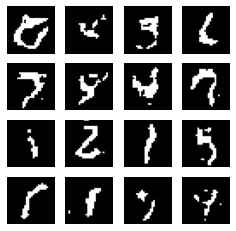

Time for epoch 46 is 405.9802680015564 sec


In [ ]:
%%time
train(train_dataset, epochs)

ref:

*   https://keras.io/examples/generative/wgan_gp/
*   https://zzu0203.github.io/deeplearning/WGAN-GP-imple/
*   https://github.com/fabulousjeong/pggan-tensorflow/blob/main/pgan.py
*   https://github.com/henry32144/pggan-tensorflow/blob/master/PGGAN-Tensorflow.ipynb
